In [195]:
%%javascript
require.config({paths: {toc: "//rawgit.com/rweigel/js-rsw/master/jupyter/toc"}});require(["toc"]);

<IPython.core.display.Javascript object>

# References

* https://www.datacamp.com/community/tutorials/random-forests-classifier-python
* https://machinelearningmastery.com/implement-random-forest-scratch-python/
* https://jakevdp.github.io/PythonDataScienceHandbook/06.00-figure-code.html#Random-Forests
* http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
* http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

# Prepare Data

In [147]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Load merged database
dfMerged = pd.read_pickle('Merged_Database.pkl')

# Create ANIMALS_BINARY column. 0 = no event; 1 = event
dfMerged.loc[dfMerged['NUM_ANIMALS'] > 0, 'ANIMALS_BINARY'] = 1
dfMerged['ANIMALS_BINARY'].fillna(0., inplace=True)

print('Number of days where one or more animal found with condition code = 1: %d' % dfMerged['ANIMALS_BINARY'].sum())

Number of days where one or more animal found with condition code = 1: 119


## Add lag columns

In [148]:
# ANIMALS_BINARY-LAG-1 value is 1 if ANIMALS_BINARY value is 1 on day before
dfMerged['ANIMALS_BINARY-LAG-1'] = dfMerged['ANIMALS_BINARY'].shift(1).fillna(0.)
# ANIMALS_BINARY-LAG-2 value is 1 if ANIMALS_BINARY value is 1 two days before
dfMerged['ANIMALS_BINARY-LAG-2'] = dfMerged['ANIMALS_BINARY'].shift(2).fillna(0.)

# Show only binary columns
binary_cols = [col for col in dfMerged if col.startswith('ANIMALS_BINARY')]
display(dfMerged[binary_cols].head(20))

,ANIMALS_BINARY,ANIMALS_BINARY-LAG-1,ANIMALS_BINARY-LAG-2
REPORT_DATE,,,
1999-03-07,1.0,0.0,0.0
1999-03-08,0.0,1.0,0.0
1999-03-09,0.0,0.0,1.0
1999-03-10,0.0,0.0,0.0
1999-03-11,0.0,0.0,0.0
1999-03-12,0.0,0.0,0.0
1999-03-13,0.0,0.0,0.0
1999-03-14,0.0,0.0,0.0
1999-03-15,0.0,0.0,0.0


## Rename columns

In [158]:
# TODO: Do this in Create_Database.ipynb

dfMerged.rename(index=str, columns={"ATMP": "Air Temperature"}, inplace=True)
dfMerged.rename(index=str, columns={"APD": "Average wave period"}, inplace=True)
dfMerged.rename(index=str, columns={"EasterlyPersistence": "Easterly Wind Persistence"}, inplace=True)
dfMerged.rename(index=str, columns={"SoutherlyPersistence": "Southerly Wind Persistence"}, inplace=True)
dfMerged.rename(index=str, columns={"BAR": "Barometric Pressure"}, inplace=True)
dfMerged.rename(index=str, columns={"DPD": "Dominant wave period"}, inplace=True)
dfMerged.rename(index=str, columns={"GST": "Peak gust speed"}, inplace=True)
dfMerged.rename(index=str, columns={"WD": "Wind Direction"}, inplace=True)
dfMerged.rename(index=str, columns={"WSPD": "Wind Speed"}, inplace=True)
dfMerged.rename(index=str, columns={"WTMP": "Sea Surface Temperature"}, inplace=True)
dfMerged.rename(index=str, columns={"WVHT": "Significant wave height"}, inplace=True)
dfMerged.rename(index=str, columns={"FRDH": "Fredericksburg H"}, inplace=True)
dfMerged.rename(index=str, columns={"FRDV": "Fredericksburg V"}, inplace=True)
dfMerged.rename(index=str, columns={"OTTH": "Ottawa H"}, inplace=True)
dfMerged.rename(index=str, columns={"OTTV": "Ottawa V"}, inplace=True)
dfMerged.rename(index=str, columns={"dH": "Fredericksburg H - Ottawa H"}, inplace=True)
dfMerged.rename(index=str, columns={"dV": "Fredericksburg V - Ottawa V"}, inplace=True)

# Remove SPECIES_*, NUM_ANIMALS, and CONDITION columns
# TODO: Use "exclude_pattern" and "exclude_exact"; similar for include.
import re
columns = []
exclude = 'SPECIES_|NUM_ANIMALS|CONDITION'
include = '.*'
for c in dfMerged.columns.values:
    if re.search(exclude, c) == None and c != 'ANIMALS_BINARY': 
        if re.search(include,c):
            columns.append(c)

print("Columns")            
display(columns)

Columns


['Fredericksburg H',
 'Fredericksburg V',
 'Ottawa H',
 'Ottawa V',
 'Fredericksburg H - Ottawa H',
 'Fredericksburg V - Ottawa V',
 'Kp_index',
 'Sunspot_No',
 'Dst_index',
 'AE_index',
 'Proton_flux_gt30MeV',
 'Proton_flux_gt60MeV',
 'High Tide Ave',
 'Low Tide Ave',
 'High Tide Max',
 'High Tide Min',
 'Low Tide Max',
 'Low Tide Min',
 'Average wave period',
 'Air Temperature',
 'Barometric Pressure',
 'Dominant wave period',
 'Easterly Wind Persistence',
 'Peak gust speed',
 'Southerly Wind Persistence',
 'Wind Direction',
 'Wind Speed',
 'Sea Surface Temperature',
 'Significant wave height',
 'ANIMALS_BINARY-LAG-1',
 'ANIMALS_BINARY-LAG-2']

# Simple Classifiers

## `ANIMALS_BINARY-LAG-1 = 0 or 1` outcomes

In [173]:
pd.crosstab(dfMerged['ANIMALS_BINARY'],dfMerged['ANIMALS_BINARY-LAG-1'])

ANIMALS_BINARY-LAG-1,0.0,1.0
ANIMALS_BINARY,,
0.0,5455,97
1.0,98,21


## `ANIMALS_BINARY-LAG-{0,1} = {0,1}` outcomes

In [197]:
data = dfMerged[ (dfMerged['ANIMALS_BINARY-LAG-2'] == 0) ]
print("ANIMALS_BINARY-LAG-2 = 0")
display(pd.crosstab(data['ANIMALS_BINARY'], data['ANIMALS_BINARY-LAG-1']))

ANIMALS_BINARY-LAG-2 = 0


ANIMALS_BINARY-LAG-1,0.0,1.0
ANIMALS_BINARY,,
0.0,5365,84
1.0,91,13


In [198]:
data = dfMerged[ (dfMerged['ANIMALS_BINARY-LAG-2'] == 1) ]
print("ANIMALS_BINARY-LAG-2 = 1")
display(pd.crosstab(data['ANIMALS_BINARY'], data['ANIMALS_BINARY-LAG-1']))

ANIMALS_BINARY-LAG-2 = 1


ANIMALS_BINARY-LAG-1,0.0,1.0
ANIMALS_BINARY,,
0.0,90,13
1.0,7,8


# Single input

## Run

In [164]:
# Quantity to be predicted
y = dfMerged['ANIMALS_BINARY']

D1 = np.zeros([len(columns),6]) # Each column is a repetition-averaged metric, each row is a variable
C1 = {} # Each element contains repetition-averaged metrics for a variable
Nr = 10 # Number of repetitions

ci = 0
for c in columns:
    C1[c] = {}
    C1[c]['accuracy'] = np.zeros(Nr)
    C1[c]['C_00'] = np.zeros(Nr)    
    C1[c]['C_01'] = np.zeros(Nr)    
    C1[c]['C_10'] = np.zeros(Nr)    
    C1[c]['C_11'] = np.zeros(Nr)    

    for i in range(0,Nr):

        X = dfMerged[c]
        X = X.fillna(0.)
        
        # Need to better understand reason for need for reshape here but not when two inputs are used
        X_train, X_test, y_train, y_test = train_test_split(X.values.reshape(-1, 1), y, test_size=0.5)

        # Create a Classifier
        clf = RandomForestClassifier(n_estimators=10, max_depth=2, class_weight='balanced')

        # Train the model
        clf.fit(X_train, y_train)

        # Compute predictions
        y_pred = clf.predict(X_test)

        # Compute metrics
        a = metrics.accuracy_score(y_test, y_pred)
        cm = metrics.confusion_matrix(y_test,y_pred)
        
        cs = "%d, %d, %d, %d" % (cm[0,0], cm[0,1], cm[1,0], cm[1,1])
        print("%s: %.4f; %s" % (c, a, cs))
        C1[c]['accuracy'][i] = a
        C1[c]['C_00'][i] = cm[0,0]
        C1[c]['C_01'][i] = cm[0,1]
        C1[c]['C_10'][i] = cm[1,0]
        C1[c]['C_11'][i] = cm[1,1]

    C1[c]['accuracy_ave'] = np.average(C1[c]['accuracy']) 
    C1[c]['accuracy_std'] = np.std(C1[c]['accuracy']) 
    C1[c]['C_00_ave'] = np.average(C1[c]['C_00']) 
    C1[c]['C_01_ave'] = np.average(C1[c]['C_01']) 
    C1[c]['C_10_ave'] = np.average(C1[c]['C_10']) 
    C1[c]['C_11_ave'] = np.average(C1[c]['C_11'])

    cs = "%.4f; %d, %d, %d, %d" % (C1[c]['accuracy_ave'], C1[c]['C_00_ave'], C1[c]['C_01_ave'], C1[c]['C_10_ave'], C1[c]['C_11_ave'])
    cs2 = "%.4f;" % (C1[c]['accuracy_std'])

    print('----')
    print("%s: %s | %s" % (c, cs, cs2))
    print('----')

    D1[ci,:] = [C1[c]['accuracy_ave'], C1[c]['accuracy_std'], C1[c]['C_00_ave'], C1[c]['C_01_ave'], C1[c]['C_10_ave'], C1[c]['C_11_ave']]
    ci = ci + 1

Fredericksburg H: 0.6474; 1816, 967, 33, 20
Fredericksburg H: 0.4993; 1385, 1393, 27, 31
Fredericksburg H: 0.6135; 1710, 1064, 32, 30
Fredericksburg H: 0.4838; 1338, 1435, 29, 34
Fredericksburg H: 0.7549; 2130, 651, 44, 11
Fredericksburg H: 0.7906; 2231, 552, 42, 11
Fredericksburg H: 0.7320; 2060, 721, 39, 16
Fredericksburg H: 0.8724; 2470, 307, 55, 4
Fredericksburg H: 0.7384; 2080, 700, 42, 14
Fredericksburg H: 0.6770; 1904, 876, 40, 16
----
Fredericksburg H: 0.6809; 1912, 866, 38, 18 | 0.1173;
----
Fredericksburg V: 0.5624; 1572, 1204, 37, 23
Fredericksburg V: 0.4358; 1194, 1588, 12, 42
Fredericksburg V: 0.6065; 1699, 1074, 42, 21
Fredericksburg V: 0.7976; 2250, 528, 46, 12
Fredericksburg V: 0.9168; 2597, 184, 52, 3
Fredericksburg V: 0.8427; 2384, 396, 50, 6
Fredericksburg V: 0.7673; 2163, 605, 55, 13
Fredericksburg V: 0.5462; 1526, 1262, 25, 23
Fredericksburg V: 0.7193; 2030, 748, 48, 10
Fredericksburg V: 0.4862; 1348, 1428, 29, 31
----
Fredericksburg V: 0.6681; 1876, 901, 39, 18 | 

Low Tide Min: 0.8170; 2302, 471, 48, 15
Low Tide Min: 0.7105; 2000, 781, 40, 15
Low Tide Min: 0.2789; 744, 2030, 15, 47
Low Tide Min: 0.7796; 2193, 579, 46, 18
Low Tide Min: 0.7352; 2069, 719, 32, 16
----
Low Tide Min: 0.6531; 1830, 947, 36, 22 | 0.1609;
----
Average wave period: 0.8417; 2371, 403, 46, 16
Average wave period: 0.7571; 2127, 649, 40, 20
Average wave period: 0.8082; 2273, 506, 38, 19
Average wave period: 0.8082; 2274, 502, 42, 18
Average wave period: 0.8512; 2400, 373, 49, 14
Average wave period: 0.5631; 1565, 1214, 25, 32
Average wave period: 0.8226; 2319, 455, 48, 14
Average wave period: 0.8530; 2403, 369, 48, 16
Average wave period: 0.5532; 1539, 1241, 26, 30
Average wave period: 0.6037; 1692, 1095, 29, 20
----
Average wave period: 0.7462; 2096, 680, 39, 19 | 0.1167;
----
Air Temperature: 0.8054; 2266, 506, 46, 18
Air Temperature: 0.6283; 1745, 1028, 26, 37
Air Temperature: 0.6213; 1725, 1053, 21, 37
Air Temperature: 0.5719; 1580, 1195, 19, 42
Air Temperature: 0.5712; 

## Results

In [165]:
import pandas
names = ['accuracy_ave', 'accuracy_std', 'True negative', 'False positive', 'False negative', 'True positive']
df = pandas.DataFrame(D1, columns, names)
df.sort_values(by=['accuracy_ave'], ascending=False)

,accuracy_ave,accuracy_std,True negative,False positive,False negative,True positive
ANIMALS_BINARY-LAG-1,0.964669,0.001783,2724.8,49.5,50.7,11.0
ANIMALS_BINARY-LAG-2,0.962482,0.001840,2722.4,52.9,53.5,7.2
Average wave period,0.746192,0.116726,2096.3,680.7,39.1,19.9
Southerly Wind Persistence,0.742560,0.138891,2089.7,687.1,43.0,16.2
High Tide Max,0.714140,0.119738,2006.7,770.2,40.5,18.6
Ottawa H,0.704337,0.126284,1979.7,799.0,39.5,17.8
Kp_index,0.701763,0.147205,1972.4,803.5,42.3,17.8
Wind Direction,0.698378,0.118785,1955.8,820.5,34.9,24.8
High Tide Ave,0.694464,0.173132,1952.9,822.8,43.7,16.6
Dominant wave period,0.683463,0.143797,1914.3,861.6,36.1,24.0


# Two inputs, one is output(t-1)

## Run

In [168]:
# Remove column that will be included always
columns = [c for c in columns if 'ANIMALS_BINARY-LAG-1' != c]

In [169]:
# Quantity to be predicted
y = dfMerged['ANIMALS_BINARY']

D2 = np.zeros([len(columns),6]) # Each column is a repetition-averaged metric, each row is a variable
C2 = {} # Each element contains repetition-averaged metrics for a variable
Nr = 10 # Number of repetitions

ci = 0
for c in columns:
    C2[c] = {}
    C2[c]['accuracy'] = np.zeros(Nr)
    C2[c]['C_00'] = np.zeros(Nr)    
    C2[c]['C_01'] = np.zeros(Nr)    
    C2[c]['C_10'] = np.zeros(Nr)    
    C2[c]['C_11'] = np.zeros(Nr)    
    for i in range(0,10):

        cols = ['ANIMALS_BINARY-LAG-1',c]     
        X = dfMerged[cols]
        X = X.fillna(0.)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

        # Create a Gaussian Classifier
        clf = RandomForestClassifier(n_estimators=10, max_depth=2, class_weight='balanced')

        # Train the model using the training sets y_pred=clf.predict(X_test)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        a = metrics.accuracy_score(y_test, y_pred)
        cm = metrics.confusion_matrix(y_test, y_pred)

        cs = "%d, %d, %d, %d" % (cm[0,0], cm[0,1], cm[1,0], cm[1,1])

        # Model Accuracy, how often is the classifier correct?
        print("Accuracy: %.4f; var: %s; %s" % (a, c, cs))
        C2[c]['accuracy'][i] = a
        C2[c]['C_00'][i] = cm[0,0]
        C2[c]['C_01'][i] = cm[0,1]
        C2[c]['C_10'][i] = cm[1,0]
        C2[c]['C_11'][i] = cm[1,1]

    C2[c]['accuracy_ave'] = np.average(C[c]['accuracy']) 
    C2[c]['accuracy_std'] = np.std(C[c]['accuracy']) 
    C2[c]['C_00_ave'] = np.average(C[c]['C_00']) 
    C2[c]['C_01_ave'] = np.average(C[c]['C_01']) 
    C2[c]['C_10_ave'] = np.average(C[c]['C_10']) 
    C2[c]['C_11_ave'] = np.average(C[c]['C_11']) 

    cs = "%.4f; %d, %d, %d, %d" % (C2[c]['accuracy_ave'], C2[c]['C_00_ave'], C2[c]['C_01_ave'], C2[c]['C_10_ave'], C2[c]['C_11_ave'])
    cs2 = "%.4f;" % (C2[c]['accuracy_std'])

    print('----')
    print("%s: %s | %s" % (c, cs, cs2))
    print('----')

    D2[ci,:] = [C2[c]['accuracy_ave'], C2[c]['accuracy_std'], C2[c]['C_00_ave'], C2[c]['C_01_ave'], C2[c]['C_10_ave'], C2[c]['C_11_ave']]
    ci = ci + 1

Accuracy: 0.8872; var: Fredericksburg H; 2504, 271, 49, 12
Accuracy: 0.4940; var: Fredericksburg H; 1372, 1410, 25, 29
Accuracy: 0.4245; var: Fredericksburg H; 1165, 1613, 19, 39
Accuracy: 0.6975; var: Fredericksburg H; 1952, 827, 31, 26
Accuracy: 0.9277; var: Fredericksburg H; 2621, 159, 46, 10
Accuracy: 0.9394; var: Fredericksburg H; 2656, 122, 50, 8
Accuracy: 0.8329; var: Fredericksburg H; 2353, 426, 48, 9
Accuracy: 0.8858; var: Fredericksburg H; 2498, 275, 49, 14
Accuracy: 0.7426; var: Fredericksburg H; 2083, 691, 39, 23
Accuracy: 0.9390; var: Fredericksburg H; 2652, 117, 56, 11
----
Fredericksburg H: 0.9647; 2733, 44, 55, 2 | 0.0026;
----
Accuracy: 0.9457; var: Fredericksburg V; 2677, 95, 59, 5
Accuracy: 0.9711; var: Fredericksburg V; 2745, 37, 45, 9
Accuracy: 0.9658; var: Fredericksburg V; 2736, 42, 55, 3
Accuracy: 0.9711; var: Fredericksburg V; 2745, 31, 51, 9
Accuracy: 0.8946; var: Fredericksburg V; 2525, 253, 46, 12
Accuracy: 0.9351; var: Fredericksburg V; 2641, 127, 57, 11
Ac

Accuracy: 0.8216; var: Low Tide Ave; 2316, 456, 50, 14
Accuracy: 0.8272; var: Low Tide Ave; 2330, 451, 39, 16
Accuracy: 0.8269; var: Low Tide Ave; 2325, 447, 44, 20
Accuracy: 0.6661; var: Low Tide Ave; 1862, 907, 40, 27
Accuracy: 0.7648; var: Low Tide Ave; 2148, 630, 37, 21
Accuracy: 0.7401; var: Low Tide Ave; 2082, 704, 33, 17
----
Low Tide Ave: 0.8422; 2375, 400, 47, 13 | 0.0259;
----
Accuracy: 0.9140; var: High Tide Max; 2576, 198, 46, 16
Accuracy: 0.4281; var: High Tide Max; 1176, 1602, 20, 38
Accuracy: 0.9016; var: High Tide Max; 2543, 235, 44, 14
Accuracy: 0.8868; var: High Tide Max; 2503, 278, 43, 12
Accuracy: 0.5021; var: High Tide Max; 1390, 1389, 23, 34
Accuracy: 0.9644; var: High Tide Max; 2729, 56, 45, 6
Accuracy: 0.8872; var: High Tide Max; 2506, 275, 45, 10
Accuracy: 0.8240; var: High Tide Max; 2316, 462, 37, 21
Accuracy: 0.9009; var: High Tide Max; 2542, 230, 51, 13
Accuracy: 0.8893; var: High Tide Max; 2513, 276, 38, 9
----
High Tide Max: 0.8153; 2299, 474, 49, 12 | 0.0

Accuracy: 0.8480; var: Wind Direction; 2387, 388, 43, 18
----
Wind Direction: 0.9121; 2577, 197, 51, 9 | 0.0341;
----
Accuracy: 0.6851; var: Wind Speed; 1908, 861, 32, 35
Accuracy: 0.7514; var: Wind Speed; 2105, 674, 31, 26
Accuracy: 0.7553; var: Wind Speed; 2114, 661, 33, 28
Accuracy: 0.7031; var: Wind Speed; 1961, 817, 25, 33
Accuracy: 0.7849; var: Wind Speed; 2199, 576, 34, 27
Accuracy: 0.7003; var: Wind Speed; 1958, 818, 32, 28
Accuracy: 0.7059; var: Wind Speed; 1974, 809, 25, 28
Accuracy: 0.6312; var: Wind Speed; 1762, 1019, 27, 28
Accuracy: 0.6710; var: Wind Speed; 1871, 900, 33, 32
Accuracy: 0.7260; var: Wind Speed; 2035, 746, 31, 24
----
Wind Speed: 0.9002; 2544, 234, 48, 8 | 0.0296;
----
Accuracy: 0.6636; var: Sea Surface Temperature; 1844, 927, 27, 38
Accuracy: 0.6157; var: Sea Surface Temperature; 1707, 1068, 22, 39
Accuracy: 0.6157; var: Sea Surface Temperature; 1696, 1074, 16, 50
Accuracy: 0.6072; var: Sea Surface Temperature; 1683, 1092, 22, 39
Accuracy: 0.6142; var: Sea 

## Results

In [171]:
import pandas
df = pandas.DataFrame(D2, columns, ['accuracy_ave', 'accuracy_std', 'True negative', 'False positive', 'False negative', 'True positive'])
df.sort_values(by=['accuracy_ave'], ascending=False)

,accuracy_ave,accuracy_std,True negative,False positive,False negative,True positive
Ottawa H,0.965197,0.004310,2735.6,39.2,59.5,1.7
Fredericksburg V,0.965056,0.003679,2735.0,41.1,58.0,1.9
Ottawa V,0.964986,0.003150,2733.5,40.7,58.6,3.2
Fredericksburg H,0.964739,0.002615,2733.2,44.3,55.7,2.8
Fredericksburg V - Ottawa V,0.964669,0.002753,2733.6,41.9,58.3,2.2
Fredericksburg H - Ottawa H,0.964069,0.003171,2732.4,43.3,58.6,1.7
AE_index,0.960614,0.001886,2721.8,54.0,57.7,2.5
ANIMALS_BINARY-LAG-2,0.952186,0.005290,2686.4,92.3,43.3,14.0
Dst_index,0.941608,0.005144,2667.1,111.0,54.6,3.3
Wind Direction,0.912130,0.034072,2577.8,197.7,51.5,9.0


Variable: Fredericksburg H     Importance: 0.64
Variable: Fredericksburg V     Importance: 0.36


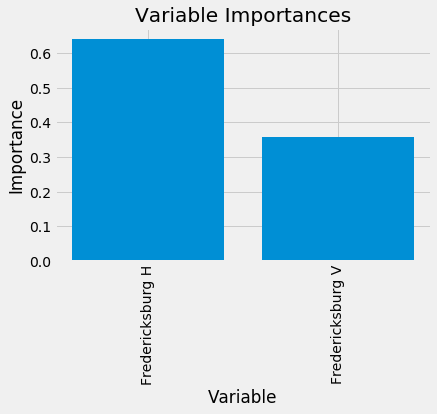

In [155]:

# Get numerical feature importances
importances = list(clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, columns, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');